# Import Toolkit

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/AI_Advanced_CK/NLP/1_Chat') # Chỉ định nơi làm việc (terminal)

In [3]:
!pip install pyvi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.9 MB/s eta 0:00:00


In [4]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pyvi import ViTokenizer
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pickle # để ghi file nhị phân
import nltk
from keras.layers import Dense, Embedding, LSTM, Dropout,SimpleRNN,LSTM,Bidirectional
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import tensorflow as tf
from keras.models import model_from_json

# Prepare Dataset

In [5]:
data = pd.read_excel('./Data4.xlsx')

In [6]:
X = data["question"]
Y = data["answer"]
print(len(X))
print(X)
print(len(Y))
print(Y.shape)

2060
0                                            Tạm biệt bot
1                                                 Goodbye
2                                    Tạm biệt mày nhé bot
3                                           Chào tạm biệt
4                                Ngày mai gặp lại nhé bot
                              ...                        
2055    ngành học nào là lựa chọn  tốt nhất trong khoa...
2056    phân biệt giữa ngành khoa học máy tính và ngàn...
2057    phân biệt, khác biệt, tốt nhất, đặc biệt, phân...
2058    Phân biệt giữa  các ngành học trong khoa công ...
2059    Nên lựa chọn ngành học nào trong khoa công ngh...
Name: question, Length: 2060, dtype: object
2060
(2060,)


## Encoder label

In [7]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(Y)

num_classes = len(np.unique(labels_encoded))
num_classes

99

In [8]:
# Chuyển nhãn sang dạng one-hot encoding
labels_one_hot = to_categorical(labels_encoded, num_classes=num_classes)

In [9]:
labels_one_hot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Tiền xử lý

In [10]:
def tienxuly(document):
  document = ViTokenizer.tokenize (document)
  # đưa về lower
  document = document.lower()
  # xóa các ký tự không cần thiết
  document = re.sub (r'[^\s\wáàảãạắằẳẵặấầẩẫậéèẻẽẹếềểễệóòỏõọốồổỗộớờởỡợíìỉĩịúùủũụứừửữựýỳỷỹỵđ_]',' ',document)
  # xóa khoảng trắng thừa
  document = re.sub (r'\s+', ' ', document).strip()
  return document

In [11]:
for i in range(0, len(X)):
  X[i]= tienxuly(X[i])
X[0:10]

0                         tạm_biệt bot
1                              goodbye
2                 tạm_biệt mày nhé bot
3                        chào tạm_biệt
4             ngày_mai gặp lại nhé bot
5                                adios
6           tạm_biệt tạm_biệt tạm_biệt
7                        see you again
8                     tạm_biệt mày nhé
9    xin chào tạm_biệt anh bạn của tôi
Name: question, dtype: object

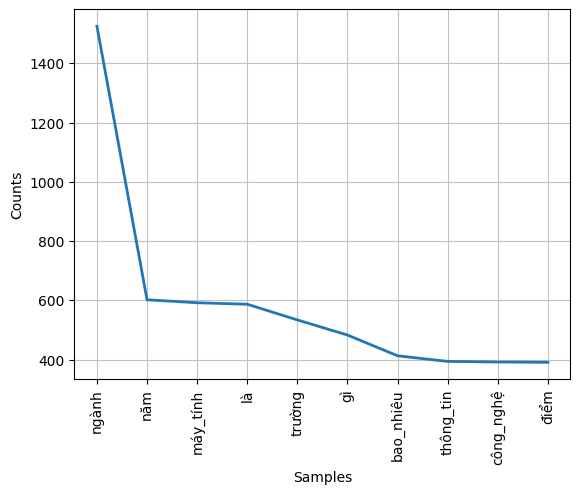

<Axes: xlabel='Samples', ylabel='Counts'>

In [12]:
tokens = []
for i in range(0, len(X)):
  for j in X[i].split():
    tokens.append(j)
freq = nltk. FreqDist(tokens)
freq.plot(10, cumulative=False)

In [13]:
# https://viblo.asia/p/xu-ly-ngon-ngu-tu-nhien-voi-python-p7-awj53XA8K6m
# Stopwords hiểu đơn giản là các từ có tần số xuất hiện nhiều như the, to
stopwords_file = open("./stop_words_Vietnamese.txt", "r")
content = stopwords_file.read()
stopwords_VN = content.splitlines()
stopwords_file.close()
#print(stopwords_VN)
#stopword trong documents
stopword = ['nghành', 'ngành', 'trường']
stopwords = stopwords_VN + stopword
def remove_stopwords (line):
  words = []
  for word in line.strip().split():
    if word not in stopwords:
      words.append(word)
  return ' ' . join(words)

for i in range(0,len (X)):
  X[i]= remove_stopwords (X[i])

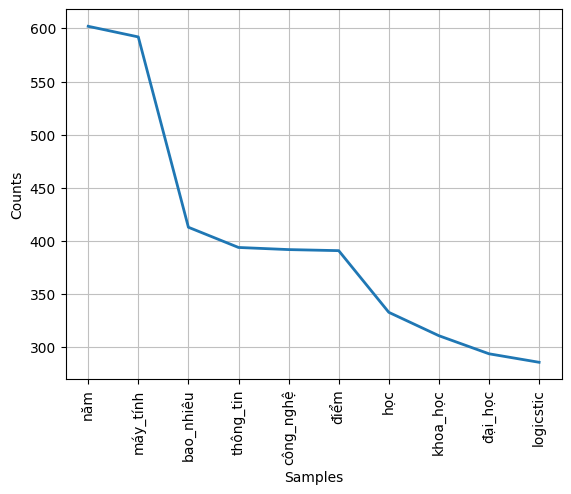

<Axes: xlabel='Samples', ylabel='Counts'>

In [14]:
tokens = []
for i in range(0, len(X)):
  for j in X[i].split():
    tokens.append(j)
freq = nltk. FreqDist(tokens)
freq.plot(10, cumulative=False)

## Tokenizer

In [15]:
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts (X)
# text_to_sequence = tokenizer.texts_to_sequences (X)
# text_to_sequence

from pyvi.ViTokenizer import ViTokenizer
from collections import Counter

# Tokenize văn bản
tokenizer = ViTokenizer()
tokenized_texts = [tokenizer.tokenize(text) for text in X]

# Tạo từ điển (dictionary)
word_counts = Counter()
for text in tokenized_texts:
    for word in text.split():
        word_counts[word] += 1

word_counts = word_counts.most_common()
print(word_counts)
word_dict = {word: index + 1 for index, (word, _) in enumerate(word_counts)}
print(word_dict)
# Ánh xạ văn bản thành danh sách các chỉ số số nguyên
text_to_sequence = []
for text in tokenized_texts:
    sequence = []
    for word in text.split():
        if word in word_dict:
            sequence.append(word_dict[word])
    text_to_sequence.append(sequence)

print(text_to_sequence)


[('năm', 602), ('máy_tính', 592), ('bao_nhiêu', 413), ('thông_tin', 394), ('công_nghệ', 392), ('điểm', 391), ('học', 333), ('khoa_học', 311), ('đại_học', 294), ('logicstic', 286), ('kĩ_thuật', 282), ('đông_á', 255), ('đầu_vào', 255), ('điểm_chuẩn', 221), ('đào_tạo', 211), ('làm', 201), ('xét', 199), ('tuyển', 199), ('nào', 163), ('2022', 145), ('khmt', 141), ('ktpm', 134), ('httt', 133), ('tốt_nghiệp', 133), ('2020', 123), ('tôi', 122), ('2018', 118), ('2019', 111), ('cntt', 104), ('trong', 101), ('sinh_viên', 94), ('tín_chỉ', 93), ('công_việc', 92), ('khoa', 87), ('ở', 77), ('chỉ_tiêu', 72), ('trình_độ', 68), ('ngoại_ngữ', 68), ('thời_gian', 67), ('tổ_hợp', 67), ('trọ', 65), ('mấy', 64), ('ngôn_ngữ', 62), ('lập_trình', 62), ('tốt', 57), ('hình_thức', 56), ('tuyển_sinh', 55), ('bot', 53), ('điều_kiện', 53), ('đạt', 52), ('đồ_án', 52), ('đi', 46), ('đối_tượng', 44), ('lĩnh_vực', 44), ('toán', 44), ('giỏi', 43), ('giá', 40), ('quân_sự', 40), ('khối', 40), ('biết', 39), ('bao_lâu', 39), (

In [16]:
# Ví dụ qua 5 từ đầu tiên
for i in range(5):
  print("\nMã hóa từ thứ: ",i)
  print("Từ gốc : ",X[i] )
  print("Mã hóa thành các chuỗi số : ", text_to_sequence[i])


Mã hóa từ thứ:  0
Từ gốc :  tạm_biệt bot
Mã hóa thành các chuỗi số :  [113, 48]

Mã hóa từ thứ:  1
Từ gốc :  goodbye
Mã hóa thành các chuỗi số :  [198]

Mã hóa từ thứ:  2
Từ gốc :  tạm_biệt mày nhé bot
Mã hóa thành các chuỗi số :  [113, 78, 133, 48]

Mã hóa từ thứ:  3
Từ gốc :  chào tạm_biệt
Mã hóa thành các chuỗi số :  [105, 113]

Mã hóa từ thứ:  4
Từ gốc :  ngày_mai gặp nhé bot
Mã hóa thành các chuỗi số :  [234, 235, 133, 48]


In [17]:
#tìm chiều dài của chuỗi dài nhất
max_length_sequence = max([len(i) for i in text_to_sequence])
padded_zeros_sequence = pad_sequences (text_to_sequence, maxlen = max_length_sequence, padding= "pre")
# padding "pre" thêm 8 vào phía trước, Post thêm 9 vào phía sau của text_to_sequence
padded_zeros_sequence

array([[  0,   0,   0, ...,   0, 113,  48],
       [  0,   0,   0, ...,   0,   0, 198],
       [  0,   0,   0, ...,  78, 133,  48],
       ...,
       [  0,   0,   0, ..., 104,  93,   7],
       [  0,   0,   0, ...,  34,   5,   4],
       [  0,   0,   0, ...,  34,   5,   4]], dtype=int32)

## Train - Test Split

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(padded_zeros_sequence, labels_one_hot, test_size=0.1, random_state=0)
X_test.shape
callback = tf.keras.callbacks. EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)
# TOT_SIZE = len(tokenizer.word_index)+1
TOT_SIZE = len(word_dict)+1

# Model

## RNN Model

In [ ]:
def RNN_model():
  model = Sequential()
  model.add(Embedding (input_dim=TOT_SIZE, output_dim= 16, input_length=max_length_sequence))
  model.add(SimpleRNN(300))
  model.add(Dense (200, activation='relu'))
  model.add(Dense (num_classes, activation='softmax')) #num_classes = 99
  return model

rnn_model = RNN_model()
rnn_model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 13, 16)            4960      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 300)               95100     
                                                                 
 dense_4 (Dense)             (None, 200)               60200     
                                                                 
 dense_5 (Dense)             (None, 99)                19899     
                                                                 
Total params: 180159 (703.75 KB)
Trainable params: 180159 (703.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
print(X_train.shape, Y_train.shape)

(1854, 13) (1854, 99)


## BiLSTM

In [19]:
def Bidirectional_model():
  model = Sequential()
  model.add(Embedding (input_dim=TOT_SIZE, output_dim= 16, input_length=max_length_sequence))
  model.add(Bidirectional (LSTM(500)))
  model.add(Dense (400, activation='relu'))
  model.add(Dense (300, activation='relu'))
  model.add(Dense (200, activation='relu'))
  model.add(Dense (num_classes, activation='softmax'))
  return model

bilstm_model = Bidirectional_model()
bilstm_model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
bilstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 13, 16)            4928      
                                                                 
 bidirectional (Bidirection  (None, 1000)              2068000   
 al)                                                             
                                                                 
 dense (Dense)               (None, 400)               400400    
                                                                 
 dense_1 (Dense)             (None, 300)               120300    
                                                                 
 dense_2 (Dense)             (None, 200)               60200     
                                                                 
 dense_3 (Dense)             (None, 99)                19899     
                                                        

# Training

In [20]:
# model = model1
# model = rnn_model
# model = lstm_model
# model = rnn_model
model = bilstm_model

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
checkpoint = ModelCheckpoint('./Phuc_Save/BiLSTM_model.h5', monitor='val_loss', verbose=1, save_best_only=True)

H = model.fit(X_train, Y_train, epochs=10, batch_size=16,
                            validation_data=(X_test, Y_test),
                            callbacks=[early_stopping, checkpoint])

# Accessing training history
print("Training History:", H.history)

Epoch 1/10
116/116 [==============================] - ETA: 0s - loss: 4.3028 - accuracy: 0.0550
Epoch 1: val_loss improved from inf to 3.88294, saving model to ./Phuc_Save/BiLSTM_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


116/116 [==============================] - 40s 309ms/step - loss: 4.3028 - accuracy: 0.0550 - val_loss: 3.8829 - val_accuracy: 0.0777
Epoch 2/10
116/116 [==============================] - ETA: 0s - loss: 3.5676 - accuracy: 0.0901
Epoch 2: val_loss improved from 3.88294 to 3.68340, saving model to ./Phuc_Save/BiLSTM_model.h5
116/116 [==============================] - 26s 225ms/step - loss: 3.5676 - accuracy: 0.0901 - val_loss: 3.6834 - val_accuracy: 0.1311
Epoch 3/10
116/116 [==============================] - ETA: 0s - loss: 2.9880 - accuracy: 0.1602
Epoch 3: val_loss improved from 3.68340 to 2.83906, saving model to ./Phuc_Save/BiLSTM_model.h5
116/116 [==============================] - 23s 196ms/step - loss: 2.9880 - accuracy: 0.1602 - val_loss: 2.8391 - val_accuracy: 0.1893
Epoch 4/10
116/116 [==============================] - ETA: 0s - loss: 2.5178 - accuracy: 0.2222
Epoch 4: val_loss improved from 2.83906 to 2.48549, saving model to ./Phuc_Save/BiLSTM_model.h5
116/116 [=============

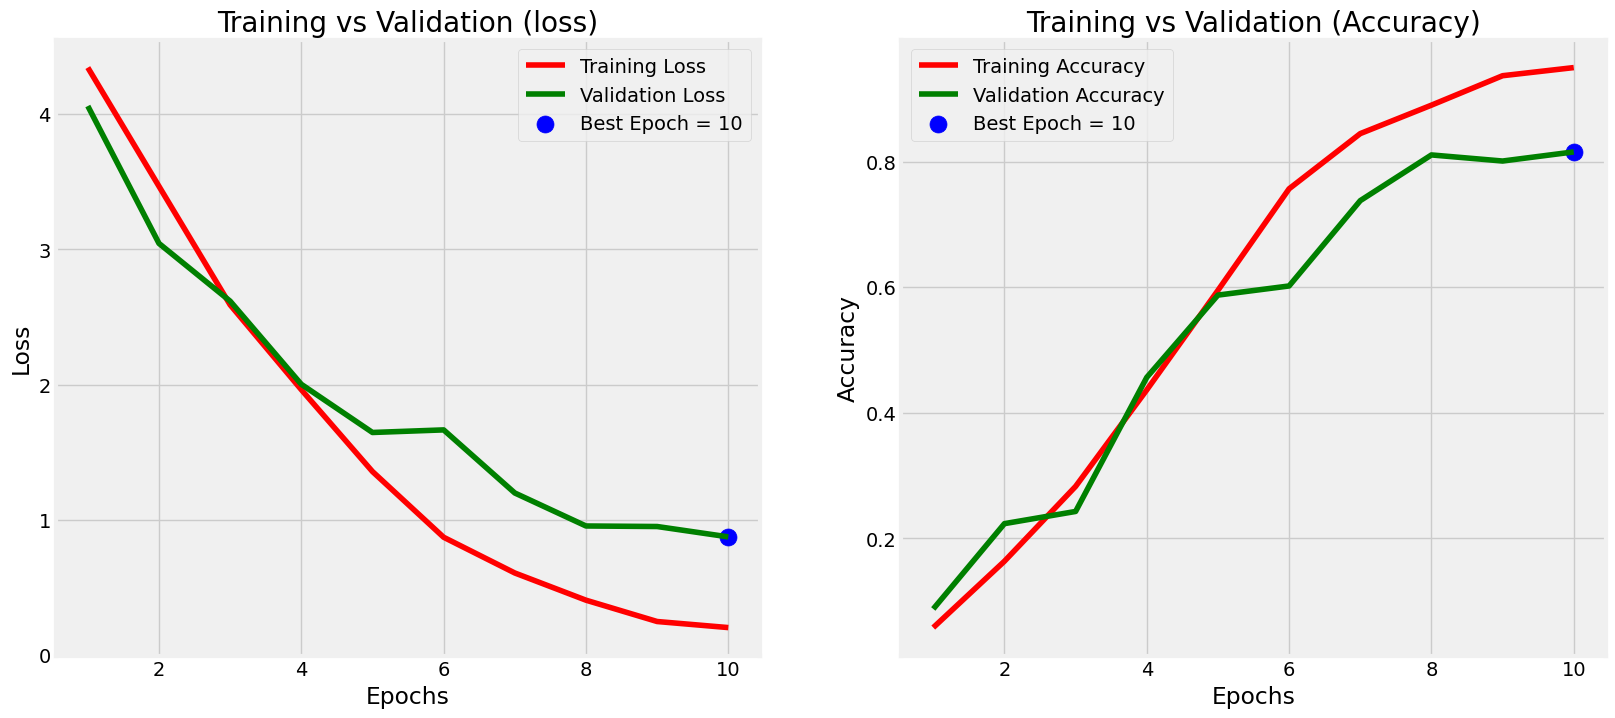

In [ ]:
train_acc = H.history['accuracy']
train_loss = H.history['loss']

val_acc = H.history['val_accuracy']
val_loss = H.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)

val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_label = f'Best Epoch = {str(index_acc + 1)}'

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r', label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss +1 , val_lowest , s = 150 , c = 'blue' , label = loss_label)
plt.title('Training vs Validation (loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r', label= 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s= 150 , c = 'blue' , label= acc_label)
plt.title('Training vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# Test

In [ ]:
def textsToSequences(text):
    sequence = []
    for word in text.split():
        if word in word_dict:
            sequence.append(word_dict[word])
    return sequence

In [ ]:
new_question = "làm thế nào để có học bổng ?"

# Tiền xử lý câu hỏi mới
new_question = tienxuly(new_question)
new_question = remove_stopwords(new_question)

# Chuyển câu hỏi thành vector
new_sequence = [textsToSequences(new_question)]
new_padded = pad_sequences(new_sequence, maxlen=max_length_sequence, padding="pre")

# Dự đoán câu trả lời
prediction = model.predict(new_padded)

# Giải mã nhãn
predicted_label = le.inverse_transform([np.argmax(prediction)])
print("Câu trả lời dự đoán:", predicted_label[0])

1/1 [==============================] - 0s 342ms/step
Câu trả lời dự đoán: Điều kiện học bổng: không trượt môn nào, học trên 15 tín trên kì, điểm tích lũy kì thuộc top của ngành


In [ ]:
#@title embedings
new_question = "Nguyễn Công Cường là ai ?"

# Tiền xử lý câu hỏi mới
new_question = tienxuly(new_question)
new_question = remove_stopwords(new_question)

# Chuyển câu hỏi thành vector
# new_sequence = tokenizer.texts_to_sequences([new_question])
new_sequence = [textsToSequences(new_question)]
new_padded = pad_sequences(new_sequence, maxlen=max_length_sequence, padding="pre")

modelx = Sequential()
modelx.add(Embedding (input_dim=TOT_SIZE, output_dim= 16, input_length=max_length_sequence))

# Lấy embedding của chuỗi
embeddings = modelx.predict(new_padded)
print("Embeddings:", embeddings)

1/1 [==============================] - 0s 147ms/step
Embeddings: [[[-3.11288834e-02  4.98544425e-04 -2.51351483e-02  2.00061835e-02
   -2.20130216e-02 -4.01936471e-04 -1.44021623e-02 -3.60395201e-02
    4.14001979e-02 -5.03367186e-03  3.00318636e-02 -1.24405399e-02
    9.41639021e-03  3.39940898e-02  4.51026075e-02 -1.68911815e-02]
  [-3.11288834e-02  4.98544425e-04 -2.51351483e-02  2.00061835e-02
   -2.20130216e-02 -4.01936471e-04 -1.44021623e-02 -3.60395201e-02
    4.14001979e-02 -5.03367186e-03  3.00318636e-02 -1.24405399e-02
    9.41639021e-03  3.39940898e-02  4.51026075e-02 -1.68911815e-02]
  [-3.11288834e-02  4.98544425e-04 -2.51351483e-02  2.00061835e-02
   -2.20130216e-02 -4.01936471e-04 -1.44021623e-02 -3.60395201e-02
    4.14001979e-02 -5.03367186e-03  3.00318636e-02 -1.24405399e-02
    9.41639021e-03  3.39940898e-02  4.51026075e-02 -1.68911815e-02]
  [-3.11288834e-02  4.98544425e-04 -2.51351483e-02  2.00061835e-02
   -2.20130216e-02 -4.01936471e-04 -1.44021623e-02 -3.6039520

NameError: name 'sequences' is not defined

In [ ]:
# Chuyển đổi từ thành chỉ số
word = "ai"
try:
  word_index_in_vocab = word_dict[word]

  print(f"Chỉ số của từ '{word}':", word_index_in_vocab)  # Chỉ số của từ 'thích': 4

  # Tạo chuỗi chứa chỉ số của từ (dạng mảng 2D để phù hợp với yêu cầu của mô hình)
  word_sequence = np.array([[word_index_in_vocab]])
  print("Chuỗi chứa chỉ số của từ:", word_sequence)

  # Tính toán embedding cho từ
  embedding_of_word = modelx.predict(word_sequence)
  print(f"Embedding của từ '{word}':", embedding_of_word)

except:
  print("tu nay ko co trong tu dien")

Chỉ số của từ 'ai': 102
Chuỗi chứa chỉ số của từ: [[102]]
1/1 [==============================] - 0s 36ms/step
Embedding của từ 'ai': [[[ 0.03644681 -0.02364022  0.04151     0.01136875 -0.01387825
   -0.0448491  -0.03617674  0.00873995  0.0452573   0.02836746
    0.02870599  0.03559833  0.00795238  0.00249635 -0.02614223
   -0.0189032 ]]]
